# Greenland peripherial glacier pre-image download processing

#### Jukes Liu
__Last modified 10-15-2019.__

## 1) Import packages, set base path, set glaciers of interest by BoxID

In [7]:
import subprocess
import numpy as np
import os
import pandas as pd
import rasterio
import fiona
from shapely.geometry import Polygon, Point
import shapely
import shutil
from PIL import Image
import matplotlib.image as mpimg
from scipy.misc import imsave
import scipy
import math

#SET basepath to your own folder
basepath='/home/jukes/Documents/Sample_glaciers/'
downloadpath = '/media/jukes/jukes1/LS8aws/'

#ENTER list of glaciers of interest by BoxID
#make this into a widget where you can enter them in?
#BOXIDS = ['001', '002', '004', '033', '120', '174', '235', '259', '277', '531', '147', '148', '150', '152', '190', '191', '192', '193', '194', '195', '195','213', '214']
# sample the SE glaciers
# BoxIDs = np.arange(100, 300, 5)
# BoxIDs = list(map(str, BoxIDs))
# print(BoxIDs)
# BOXIDS = BoxIDs

['100', '105', '110', '115', '120', '125', '130', '135', '140', '145', '150', '155', '160', '165', '170', '175', '180', '185', '190', '195', '200', '205', '210', '215', '220', '225', '230', '235', '240', '245', '250', '255', '260', '265', '270', '275', '280', '285', '290', '295']


In [8]:
os.chdir('/home/jukes/automated-glacier-terminus') #import necessary functions:
from automated_terminus_functions import distance

## 2) Create buffer zone around terminus boxes and rasterize/subset terminus boxes

The following code pulls the buffer distances around the terminus boxes from an existing .csv file with the exported attributes tables for the peripheral glacier terminus boxes. These buffer distances will be used to create a buffer zone to subset the Landsat scenes.

In [11]:
buffers = []
#Calculate a buffer distance around the terminus box using the UTM projected boxes
for BoxID in BOXIDS:
    buff_distances = []

    for file in os.listdir(basepath+'Box'+BoxID+'/'):
        if 'UTM' in file and '.shp' in file and "Box" in file:
            print(file)
            boxpath = basepath+"Box"+BoxID+"/"+file
#             print(boxpath)  
            termbox = fiona.open(boxpath)
            #grab the box feature:
            box = termbox.next()
            box_geom= box.get('geometry')
            box_coords = box_geom.get('coordinates')[0]
#             print(box_geom)
            
            points = []
            for coord_pair in box_coords:
                lat = coord_pair[0]; lon = coord_pair[1]; points.append([lat, lon])
            
            #Calculate distance between 1 and 2 and distance between 2 and 3
            #pick the longer one (length)
            coord1 = points[0]; coord2 = points[1]; coord3 = points[2]   
            dist1 = distance(coord1[0], coord1[1], coord2[0], coord2[1]);
            dist2 = distance(coord2[0], coord2[1], coord3[0], coord3[1])  
            buff_dist = int(np.max([dist1, dist2]))
#             print(buff_dist)
            buff_distances.append(buff_dist)
    
    buffer = buff_distances[0]; buffers.append(buffer)

buff_df = pd.DataFrame(list(zip(BOXIDS, buffers)), columns=['BoxID', 'Buff_dist_m'])
buff_df

Box100_UTM_23.shp
Box105_UTM_23.shp
Box110_UTM_23.shp
Box115_UTM_23.shp
Box120_UTM_23.shp
Box120_UTM_24.shp
Box125_UTM_23.shp
Box125_UTM_24.shp
Box130_UTM_24.shp
Box130_UTM_23.shp
Box135_UTM_23.shp
Box135_UTM_24.shp
Box140_UTM_23.shp
Box140_UTM_24.shp
Box145_UTM_24.shp
Box145_UTM_23.shp
Box150_UTM_24.shp
Box150_UTM_23.shp
Box155_UTM_23.shp
Box155_UTM_24.shp
Box160_UTM_23.shp
Box160_UTM_24.shp
Box165_UTM_23.shp
Box165_UTM_24.shp
Box170_UTM_23.shp
Box170_UTM_24.shp
Box175_UTM_24.shp
Box175_UTM_23.shp
Box180_UTM_24.shp
Box180_UTM_23.shp
Box185_UTM_24.shp
Box185_UTM_23.shp
Box190_UTM_24.shp
Box190_UTM_23.shp
Box195_UTM_24.shp
Box195_UTM_23.shp
Box200_UTM_24.shp
Box200_UTM_23.shp
Box205_UTM_23.shp
Box205_UTM_24.shp
Box210_UTM_24.shp
Box210_UTM_23.shp
Box215_UTM_24.shp
Box215_UTM_23.shp
Box220_UTM_24.shp
Box225_UTM_24.shp
Box230_UTM_23.shp
Box230_UTM_24.shp
Box235_UTM_23.shp
Box235_UTM_24.shp
Box240_UTM_24.shp
Box245_UTM_24.shp
Box250_UTM_24.shp
Box255_UTM_24.shp
Box260_UTM_24.shp
Box260_UTM

/home/jukes/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: FionaDeprecationWarning: Collection.__next__() is buggy and will be removed in Fiona 2.0. Switch to `next(iter(collection))`.
  del sys.path[0]


,BoxID,Buff_dist_m
0,100,2218
1,105,660
2,110,1517
3,115,2301
4,120,1048
5,125,934
6,130,703
7,135,1539
8,140,1311
9,145,1064


In [12]:
buff_distances

[1538, 1538]

The next section creates a buffer zone using GDAL command **ogr2ogr** with the following syntax:

    ogr2ogr Buffer###.shp path_to_terminusbox###.shp  -dialect sqlite -sql "SELECT ST_Buffer(geometry, buffer_distance) AS geometry,*FROM 'Box###'" -f "ESRI Shapefile"

In [13]:
for index, row in buff_df.iterrows():
    BoxID = row['BoxID']
    buff_dist = str(row['Buff_dist_m'])
    
    #SET path to the terminus box shapefiles
    terminusbox_path = basepath+"Box"+BoxID+"/Box"+BoxID+".shp"
    outputbuffer_path = basepath+"Box"+BoxID+"/Buffer"+BoxID+".shp"
    
    #SET buffer command and print to check it
    buffer_cmd = 'ogr2ogr '+outputbuffer_path+" "+terminusbox_path+' -dialect sqlite -sql "SELECT ST_Buffer(geometry, '+buff_dist+") AS geometry,*FROM 'Box"+BoxID+"'"+'" -f "ESRI Shapefile"'
    print(buffer_cmd)
    
    subprocess.call(buffer_cmd, shell=True) 
    print("Box"+BoxID)

ogr2ogr /home/jukes/Documents/Sample_glaciers/Box100/Buffer100.shp /home/jukes/Documents/Sample_glaciers/Box100/Box100.shp -dialect sqlite -sql "SELECT ST_Buffer(geometry, 2218) AS geometry,*FROM 'Box100'" -f "ESRI Shapefile"
Box100
ogr2ogr /home/jukes/Documents/Sample_glaciers/Box105/Buffer105.shp /home/jukes/Documents/Sample_glaciers/Box105/Box105.shp -dialect sqlite -sql "SELECT ST_Buffer(geometry, 660) AS geometry,*FROM 'Box105'" -f "ESRI Shapefile"
Box105
ogr2ogr /home/jukes/Documents/Sample_glaciers/Box110/Buffer110.shp /home/jukes/Documents/Sample_glaciers/Box110/Box110.shp -dialect sqlite -sql "SELECT ST_Buffer(geometry, 1517) AS geometry,*FROM 'Box110'" -f "ESRI Shapefile"
Box110
ogr2ogr /home/jukes/Documents/Sample_glaciers/Box115/Buffer115.shp /home/jukes/Documents/Sample_glaciers/Box115/Box115.shp -dialect sqlite -sql "SELECT ST_Buffer(geometry, 2301) AS geometry,*FROM 'Box115'" -f "ESRI Shapefile"
Box115
ogr2ogr /home/jukes/Documents/Sample_glaciers/Box120/Buffer120.shp /h

Box275
ogr2ogr /home/jukes/Documents/Sample_glaciers/Box280/Buffer280.shp /home/jukes/Documents/Sample_glaciers/Box280/Box280.shp -dialect sqlite -sql "SELECT ST_Buffer(geometry, 1830) AS geometry,*FROM 'Box280'" -f "ESRI Shapefile"
Box280
ogr2ogr /home/jukes/Documents/Sample_glaciers/Box285/Buffer285.shp /home/jukes/Documents/Sample_glaciers/Box285/Box285.shp -dialect sqlite -sql "SELECT ST_Buffer(geometry, 1182) AS geometry,*FROM 'Box285'" -f "ESRI Shapefile"
Box285
ogr2ogr /home/jukes/Documents/Sample_glaciers/Box290/Buffer290.shp /home/jukes/Documents/Sample_glaciers/Box290/Box290.shp -dialect sqlite -sql "SELECT ST_Buffer(geometry, 1417) AS geometry,*FROM 'Box290'" -f "ESRI Shapefile"
Box290
ogr2ogr /home/jukes/Documents/Sample_glaciers/Box295/Buffer295.shp /home/jukes/Documents/Sample_glaciers/Box295/Box295.shp -dialect sqlite -sql "SELECT ST_Buffer(geometry, 1538) AS geometry,*FROM 'Box295'" -f "ESRI Shapefile"
Box295


The terminus box shapefiles are then rasterized (to be used as a mask during the WTMM filering) using the GDAL **gdal_rasterize** command and subset to the buffer zone using the GDAL **gdalwarp** command using the following syntax:

1) Rasterize

    gdal_rasterize -burn 1.0 -tr x_resolution y_resolution -a_nodata 0.0 path_to_terminusbox.shp path_to_terminusbox_raster.TIF

The x_resolution and y_resolution are set to be 15.0 (meters) to match the Landsat B8 resolution.
    
2) Subset

    gdalwarp -cutline path_to_Buffer###.shp -crop_to_cutline path_to_terminusbox_raster.TIF path_to_subset_raster_cut.TIF

In [14]:
for index, row in buff_df.iterrows():
    BoxID = row['BoxID']
    #SET path to the terminus box shapefiles
    terminusbox_path = basepath+"Box"+BoxID+"/Box"+BoxID+".shp"
    buffer_path = basepath+"Box"+BoxID+"/Buffer"+BoxID+".shp"
    
    #output raster path:
    terminusraster_path = basepath+"Box"+BoxID+"/Box"+BoxID+".TIF"
    cutraster_path = basepath+"Box"+BoxID+"/Box"+BoxID+"_raster_cut.TIF"
    
    #SET commands and print to check
    rasterize_cmd = 'gdal_rasterize -burn 1.0 -tr 15.0 15.0 -a_nodata 0.0 '+terminusbox_path+' '+terminusraster_path
    subsetbuffer_cmd = 'gdalwarp -cutline '+buffer_path+' -crop_to_cutline '+terminusraster_path+" "+cutraster_path
    #print(export_GDALpath+rasterize_cmd)
    #print(export_GDALpath+subsetbuffer_cmd)
    
    #RASTERIZE & SUBSET
    subprocess.call(rasterize_cmd, shell=True)
    subprocess.call(subsetbuffer_cmd, shell=True)
    
    print("Box"+BoxID)

Box100
Box105
Box110
Box115
Box120
Box125
Box130
Box135
Box140
Box145
Box150
Box155
Box160
Box165
Box170
Box175
Box180
Box185
Box190
Box195
Box200
Box205
Box210
Box215
Box220
Box225
Box230
Box235
Box240
Box245
Box250
Box255
Box260
Box265
Box270
Box275
Box280
Box285
Box290
Box295


## 3) Calculate average flow direction (weighted by magnitude) for each glacier

The following code processes ice velocity rasters to determine each glacier of interest's weighted average flow direction. The rasters are subset using the terminus box shapefile using a GDAL command (**gdalwarp**) with the following syntax:

    gdalwarp -cutline path_to_terminusbox.shp -crop_to_cutline path_to_input_velocity.TIF path_to_output_velocity_at_term###.TIF

In [61]:
BOXIDS = BoxIDs

In [62]:
for BoxID in BOXIDS:
    #SET paths to the terminus box shapefiles and velocity data
    terminusbox_path = basepath+"Box"+BoxID+"/Box"+BoxID+".shp"

#     for vdate in ['2014_15', '2015_16', '2016_17']:
    if True == True:
#         vdir = 'measures_velocity_dir_degree.tif'; vmag = 'greenland_vel_mosaic250_mag.tif'
        vx = 'greenland_vel_mosaic250_vx_v1.tif';vy = 'greenland_vel_mosaic250_vy_v1.tif'
        #set input paths
#         vdir_in = basepath+vdir; vmag_in = basepath+vmag
        vx_in = basepath+vx; vy_in = basepath+vy
    
        #SET output paths
#         vdir_out = basepath+"Box"+BoxID+"/Buffer"+BoxID+'_'+vdir; vmag_out = basepath+"Box"+BoxID+"/Buffer"+BoxID+'_'+vmag
        vx_out = basepath+"Box"+BoxID+"/Box"+BoxID+'_'+vx; vy_out = basepath+"Box"+BoxID+"/Box"+BoxID+'_'+vy; 
    
        #SET velocity subset commands and print to check it
        v_subset1 = 'gdalwarp -cutline '+terminusbox_path+' -crop_to_cutline '+vx_in+" "+vx_out
        v_subset2 = 'gdalwarp -cutline '+terminusbox_path+' -crop_to_cutline '+vy_in+" "+vy_out
#         print(v_subset_dir_cmd); print(v_subset_mag_cmd)

        #SUBSET velocity rasters
        subprocess.call(v_subset1, shell=True)
        subprocess.call(v_subset2, shell=True)
    
    print("Box"+BoxID)

Box100
Box110
Box115
Box120
Box130
Box135
Box140
Box150
Box155
Box160
Box175
Box180
Box185
Box190
Box195
Box200
Box205
Box210
Box220
Box225
Box235
Box240
Box245
Box255
Box260
Box265
Box270
Box280
Box285
Box290
Box152
Box149
Box148
Box147
Box174
Box191
Box192
Box193
Box194
Box213
Box214
Box219
Box277
Box279


Next, these subset velocity rasters are opened using the **rasterio** package and read into arrays. They are filtered for anomalous values and the velocity magnitudes are converted into weights. Then the **numpy.average()** function is used to calculated the weighted average flow directions where the flow directions of the pixels where the highest velocities are found are weighted more. 

The resulting average flow direction will be representative of the glacier's main flow. These directions will be used to rotate the images of the glaciers so that their flow is due right.

In [63]:
#CREATE list of glacier average flow directions:
boxes = []; avg_rot = []; max_mag = []; num_cells = []

for BoxID in BOXIDS :
    rot_angles = []; max_magnitudes = []
    
#     for vdate in ['2014_15', '2015_16', '2016_17']:
    if True == True:
        #READ velocity direction and magnitude data at terminus for each glacier into an array
        vx_name = 'greenland_vel_mosaic250_vx_v1.tif';vy_name = 'greenland_vel_mosaic250_vy_v1.tif'
        vx = rasterio.open(basepath+"Box"+BoxID+"/Box"+BoxID+'_'+vx_name, "r")
        vy = rasterio.open(basepath+"Box"+BoxID+"/Box"+BoxID+'_'+vy_name, "r") 
        vx_array = vx.read(); vy_array = vy.read()
        #remove no data values (-2000000000.0)
        vx_masked = vx_array[vx_array != -2000000000.0]; vy_masked = vy_array[vy_array != -2000000000.0]
#         print(len(vx_masked), len(vy_masked))
#         print(vx_masked.max(), vx_masked.min(), vy_masked.max(), vy_masked.min())
        
        #CALCULATE FLOW DIRECTION
        direction = np.arctan2(vy_masked, vx_masked)*180/np.pi; 
#         print(BoxID, direction.max(), direction.min())
        #transform so any negative angles are placed on 0 to 360 scale:
        if len(direction[direction < 0]) > 0:
            direction[direction < 0] = 360.0+direction[direction < 0]
#             print(BoxID, direction.max(), direction.min())
        
        #CALCULATE SPEED
        magnitude = np.sqrt((vx_masked*vx_masked) + (vy_masked*vy_masked))
#         print(magnitude.max(), magnitude.min())
        
#         print(len(direction), len(magnitude))
        
        if len(direction) > 0: # if there are velocity values remaining
            #CALCULATE the weighted average rotation angle
            #calculate weights (0 - 1) from magnitudes
            mag_range = magnitude.max() - magnitude.min()
            stretch = 1/mag_range
            weights = stretch*(magnitude - magnitude.min())
    #         print(weights.min(), weights.max()) #should be between 0 and 1
    #         print(weights.shape, masked_dir.shape)
            avg_dir = np.average(direction, weights=weights)
            print(avg_dir)
            max_magnitude = magnitude.max()*0.00273973 # conversion to m/d?
        else:
            avg_dir = np.NaN # no velocities to calculate this with
            max_magnitude = np.NaN

        #APPEND to lists:
        avg_rot.append(avg_dir)
        max_mag.append(max_magnitude)
        boxes.append(BoxID)
        num_cells.append(len(direction))
        
velocities_df = pd.DataFrame(list(zip(boxes,avg_rot, max_mag, num_cells)), columns=['BoxID','Flow_dir', 'Max_speed', 'Pixels'])
velocities_df = velocities_df.sort_values(by='BoxID')
velocities_df = velocities_df.drop_duplicates()
velocities_df

45.16191
11.955122
54.183926
284.69482
131.08037
37.495686
269.71048
90.21991
85.87299
332.59662
57.275196
326.19885
102.35444
34.894485
176.01068
16.095608
151.58388
61.46547
300.90973
129.82559
193.97168
258.1941
313.5253
82.96839
204.82167
221.21375
313.97977
231.70102
277.23193
279.45605
60.508465
251.56573
266.9979
22.610819
56.88126
229.0989
235.48155
248.77821
100.5288
344.6889
260.24182
301.74695
57.975185


,BoxID,Flow_dir,Max_speed,Pixels
0,100,45.161911,1.011741,29
1,110,11.955122,0.774739,5
2,115,54.183926,1.106937,11
3,120,284.694824,0.641524,8
4,130,131.080368,0.028833,4
5,135,37.495686,1.717245,14
6,140,269.710480,0.107777,11
33,147,266.997894,0.167617,8
32,148,251.565735,0.090716,3
31,149,NaN,NaN,0


In [75]:
# #EXPORT MAX VELOCITY AND AVERAGE FLOW DIRECTION TO A .CSV FILE
# #write the data frame to csv file
velocities_df.to_csv(path_or_buf = basepath+'Glacier_vel_measures_SE.csv', sep=',')

## 4) Rotate all images by flow direction

Read in the glacier velocity file as velocities_df if not already loaded:

In [25]:
velocities_df = pd.read_csv(basepath+'Glacier_vel_measures_SE.csv', sep=',', dtype=str)
# velocities_df = pd.read_csv(basepath+'Glacier_velocities.csv', sep=',', dtype=str, usecols=[1,2,3])
velocities_df = velocities_df.set_index('BoxID')
velocities_df

,Flow_dir,Max_speed,Pixels
BoxID,,,
100,45.16191101074219,1.0117410358633423,29
105,284.1679992675781,0.013835107928509713,2
110,11.955121994018555,0.7747390902471925,5
115,54.18392562866211,1.106937038222046,11
120,284.69482421875,0.6415244847628785,8
125,NaN,NaN,0
130,131.0803680419922,0.028833470282793046,4
135,37.49568557739258,1.7172448380322267,14
140,269.7104797363281,0.10777670406066894,11


In [60]:
# velocites_df = velocities_df.dropna()

In [29]:
#make rotated images directory in BoxID folders if it doesn't already exist
for BoxID in BOXIDS:
    if os.path.exists(downloadpath+"Box"+BoxID+'/rotated/'):
        print("Already exists.")
        #OTHERWISE, create the folder and download into it
    else:
        os.mkdir(downloadpath+"Box"+BoxID+'/rotated/')
        print("Folder made for Box"+BoxID)

Already exists.
Already exists.
Already exists.
Already exists.
Already exists.
Already exists.
Already exists.
Already exists.
Already exists.
Already exists.
Already exists.
Already exists.
Already exists.
Already exists.
Already exists.
Already exists.
Already exists.
Already exists.
Already exists.
Already exists.
Already exists.
Already exists.
Already exists.
Already exists.
Already exists.
Already exists.
Already exists.
Already exists.
Already exists.
Already exists.
Already exists.
Already exists.
Already exists.
Already exists.
Already exists.
Already exists.
Already exists.
Already exists.
Already exists.
Already exists.


In [30]:
#move box raster into reprojected folder:
for BoxID in BOXIDS:
    boxfile = 'Box'+BoxID+'_raster_cut.TIF'
    boxrasterpath = basepath+'Box'+BoxID+'/'+boxfile
    newpath = downloadpath+'Box'+BoxID+'/reprojected/'+boxfile
    
    shutil.copyfile(boxrasterpath, newpath)

In [31]:
#convert all files in reprojected folder to png from TIF
for BoxID in BOXIDS:
    command = 'cd '+downloadpath+'Box'+BoxID+'/reprojected/; '+'mogrify -format png *.TIF'
#     print(command)
    subprocess.call(command, shell=True)

In [34]:
#ROTATE THE IMAGES IF VELOCITIES ARE GOOD
for index, row in velocities_df.iterrows():
    BoxID = index
    print(BoxID) 
    #for each file in the reprojected folder:
    for file in os.listdir(downloadpath+"Box"+BoxID+'/reprojected/'):
        if file.endswith('.png'):
#             print(file)
            img  = Image.open(downloadpath+"Box"+BoxID+'/reprojected/'+file)
            #rotate the image by the flow direction from flowspeed_df
            rotated = img.rotate(-float(row['Flow_dir']))
            rotated.save(downloadpath+"Box"+BoxID+'/rotated/R_'+file)

100
105
110
115
120
125
130
135
140
145
150
155
160
165
170
175
180
185
190
195
200
205
210
215
220
225
230
235
240
245
250
255
260
265
270
275
280
285
290
295


## 5) Resize images to minimum dimensions

In [287]:
# #Make sure folders are removed
# for BoxID in BOXIDS:
#     if os.path.exists(downloadpath+"Box"+BoxID+'/rotated/'):
#         shutil.rmtree(downloadpath+"Box"+BoxID+'/rotated/', ignore_errors=False, onerror=None)
#     else:
#         print("Resized folder already removed")

In [35]:
for index, row in velocities_df.iterrows():
    BoxID = index
    print(BoxID)
    dimensions_x = []; dimensions_y = []
    images = os.listdir(downloadpath+"Box"+BoxID+'/rotated/')
    for image in images:
        if image.endswith('.png'):
            img = mpimg.imread(downloadpath+"Box"+BoxID+'/rotated/'+image)
            dimensions_x.append(img.shape[1]); dimensions_y.append(img.shape[0])

    #find minimum dimensions
    min_y = np.min(dimensions_y); min_x = np.min(dimensions_x)
    index_y = dimensions_y.index(min_y); index_x = dimensions_x.index(min_x)
          
    if index_x != index_y:
        print('Something is funky with the image dimesions for Box'+BoxID)
    else:
        crop_y = dimensions_y[index_y]; crop_x = dimensions_x[index_y]

        #crop each image if the dimensions are larger than the minimum
        for image in images:
            if image.endswith('.png'):
                img = mpimg.imread(downloadpath+"Box"+BoxID+'/rotated/'+image)
                if img.shape[1] > crop_x or img.shape[0] > crop_y:
                    #calculate difference, and divide by 2 to get amount of rows to remove by
                    diffx_half = (img.shape[1] - crop_x)/2; diffy_half = (img.shape[0] - crop_y)/2
    #                 print(diffx_half, diffy_half)

                    #if the difference is a half pixel, make sure to remove the full value from the first side only
                    if int(diffx_half) != diffx_half:
                        #remember for image slicing y is the first dimension, x is the second
                        img_cropx = img[:, int(diffx_half):-int(diffx_half)-1]
                    #otherwise remove it from both sides:
                    else:
                        img_cropx = img[:, int(diffx_half):-int(diffx_half)]

                    #same for y
                    if int(diffy_half) != diffy_half:   
                        img_cropy = img_cropx[int(diffy_half):-int(diffy_half)-1, :]
                    #otherwise remove it from both sides:
                    else:
                        img_cropy = img_cropx[int(diffy_half):-int(diffy_half), :]

    #                 print(BoxID, crop_y, crop_x)
    #                 print(BoxID, img_cropy.shape)

                    #save over original images
                    scipy.misc.imsave(downloadpath+"Box"+BoxID+'/rotated/'+image, img_cropy)

100


/home/jukes/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


105
110
115
120
125
130
135
140
145
150
155
160
165
170
175
180
185
190
195
200
205
210
215
220
225
230
235
240
245
250
255
260
265
270
275
280
285
290
295


In [145]:
#convert all final files to pgm
for index, row in velocities_df.iterrows():
    BoxID = index
    command = 'cd '+downloadpath+'Box'+BoxID+'/rotated/; '+'mogrify -format pgm *.png'
#     print(command)
    subprocess.call(command, shell=True)

In [146]:
for index, row in velocities_df.iterrows():
    BoxID = index
    files = os.listdir(downloadpath+'Box'+BoxID+'/rotated/')
    for file in files:
        if file.startswith('R_Box'+BoxID+'_cut'):
            rpath = downloadpath+'Box'+BoxID+'/rotated/'
            os.rename(rpath+file, rpath+'R_Box'+BoxID+'_raster_cut'+file[-4:])

#### Grab fraction of total images available that were cloudy

In [105]:
pathrows_df = pd.read_csv(basepath+'LS_pathrows_SE.csv', dtype=str, usecols=[1, 2, 3],index_col='BoxID')
# pathrows_df

In [104]:
BoxIDs = []; im_tots = []; downloaded = []; fractions = [];
for index, row in velocities_df.iterrows():
    BoxID = index # grab the BoxID
    pathrows_BoxID = pathrows_df[pathrows_df.index == int(BoxID)].copy() # grab path rows for that BoxID
    
    im_tot = 0 # count number of total images
    for idx, rw in pathrows_BoxID.iterrows():
        p = rw['Path']; r = rw['Row']
        ims_pr = len(os.listdir(downloadpath+'Path'+p+'_Row'+r)) # grab number of scenes in that pathrow
        im_tot = im_tot + ims_pr
        
    # find number downloaded (not cloudy) from the BoxID folder
    counter = 0
    for file in os.listdir(downloadpath+'Box'+BoxID):
        if file.startswith('LC') and file.endswith('.TIF') and 'B8' in file:
            counter = counter + 1
            
    download_frac = int(counter/im_tot*100) # grab fraction downloaded
#     print(BoxID, im_tot, counter, download_frac)
    BoxIDs.append(BoxID); im_tots.append(im_tot); downloaded.append(counter); fractions.append(download_frac)
    
downloaded_df = pd.DataFrame(list(zip(BoxIDs, im_tots, downloaded, fractions)), columns = ['BoxID', 'Total_ims', 'Downloaded', '%'])
# downloaded_df 

In [103]:
downloaded_df.to_csv(basepath+'Images_downloaded_SE.csv')

## Now we're ready for 2D WTMM analysis!

## 6) Run Tcl scripts: 

Pull in the input BoxIDs from above.

### Run scr_gaussian.tcl with BoxIDs as input

In [72]:
inputIDs = " ".join(BOXIDS)
scr_gaussian = '/home/akhalil/src/xsmurf-2.7/main/xsmurf -nodisplay /home/jukes/Documents/Scripts/scr_gaussian.tcl '+inputIDs
print(scr_gaussian)
# subprocess.call(scr_gaussian, shell=True)

/home/akhalil/src/xsmurf-2.7/main/xsmurf -nodisplay /home/jukes/Documents/Scripts/scr_gaussian.tcl 100 110 115 120 130 135 140 147 148 150 152 155 160 174 175 180 185 190 191 192 193 194 195 200 205 210 213 214 219 220 225 235 240 245 255 260 265 270 277 279 280 285 290


## Run scr_gaussian.tcl with multiple CPUs

In [148]:
num_CPUs = 11

for index, row in downloaded_df.iterrows():
    BoxID = row['BoxID']; print("Box", BoxID)
    num_images = row['Downloaded']
    num_batches = math.ceil(num_images/num_CPUs)
    num_lastbatch = num_CPUs - (num_batches*num_CPUs - num_images)
    
    imagelist = []
    for file in os.listdir(downloadpath+'Box'+BoxID+'/rotated/'):
        if "Buffer" in file and file.endswith(".pgm"):
            imagelist.append(file)
    
    counter = 0
    for i in range(1, num_batches+1):
        if i < num_batches:
            print("Batch", i)
            for j in range(1, num_CPUs+1):
                image = imagelist[counter]
                scr = '/home/akhalil/src/xsmurf-2.7/main/xsmurf -nodisplay /home/jukes/Documents/Scripts/scr_gaussian.tcl '+BoxID+' '+image+' &'
                print("CPU", j, ':', image)
                counter = counter+1
        else:
            print("Batch", i)
            for k in range(1, num_lastbatch+1):
                image = imagelist[counter]
                scr = '/home/akhalil/src/xsmurf-2.7/main/xsmurf -nodisplay /home/jukes/Documents/Scripts/scr_gaussian.tcl '+BoxID+' '+image+' &'
                print("CPU", k, ':', image)
                counter = counter+1

        print("Wait...")
        print(counter, "images analyzed")

Box 100
Batch 1
CPU 1 : R_LC82330182015300LGN00_B8_PS_Buffer100.pgm
CPU 2 : R_LC82320182015149LGN00_B8_PS_Buffer100.pgm
CPU 3 : R_LC82320182014066LGN00_B8_PS_Buffer100.pgm
CPU 4 : R_LC82320182015005LGN00_B8_PS_Buffer100.pgm
CPU 5 : R_LC82330182015252LGN00_B8_PS_Buffer100.pgm
CPU 6 : R_LC82330182013294LGN00_B8_PS_Buffer100.pgm
CPU 7 : R_LC82320182016104LGN00_B8_PS_Buffer100.pgm
CPU 8 : R_LC82330182015348LGN00_B8_PS_Buffer100.pgm
CPU 9 : R_LC82330182015364LGN00_B8_PS_Buffer100.pgm
CPU 10 : R_LC82320182015021LGN00_B8_PS_Buffer100.pgm
CPU 11 : R_LC82330182016111LGN00_B8_PS_Buffer100.pgm
Wait...
11 images analyzed
Batch 2
CPU 1 : R_LC82320182014146LGN00_B8_PS_Buffer100.pgm
CPU 2 : R_LC82320182014210LGN00_B8_PS_Buffer100.pgm
CPU 3 : R_LC82320182015069LGN00_B8_PS_Buffer100.pgm
CPU 4 : R_LC82320182014258LGN00_B8_PS_Buffer100.pgm
CPU 5 : R_LC82320182014354LGN00_B8_PS_Buffer100.pgm
CPU 6 : R_LC82320182014194LGN00_B8_PS_Buffer100.pgm
CPU 7 : R_LC82330182013230LGN00_B8_PS_Buffer100.pgm
CPU 8 : R_L

Batch 1
CPU 1 : R_LC82320172016184LGN00_B8_PS_Buffer180.pgm
CPU 2 : R_LC82320172013271LGN00_B8_PS_Buffer180.pgm
CPU 3 : R_LC82330172013342LGN00_B8_PS_Buffer180.pgm
CPU 4 : R_LC82320172013319LGN00_B8_PS_Buffer180.pgm
CPU 5 : R_LC82320172016280LGN00_B8_PS_Buffer180.pgm
CPU 6 : R_LC82320172017074LGN00_B8_PS_Buffer180.pgm
CPU 7 : R_LC82320172016264LGN00_B8_PS_Buffer180.pgm
CPU 8 : R_LC82330172016255LGN00_B8_PS_Buffer180.pgm
CPU 9 : R_LC82330172014233LGN00_B8_PS_Buffer180.pgm
CPU 10 : R_LC82330172015108LGN00_B8_PS_Buffer180.pgm
CPU 11 : R_LC82330172015268LGN00_B8_PS_Buffer180.pgm
Wait...
11 images analyzed
Batch 2
CPU 1 : R_LC82320172016312LGN00_B8_PS_Buffer180.pgm
CPU 2 : R_LC82330172016031LGN00_B8_PS_Buffer180.pgm
CPU 3 : R_LC82320172016104LGN00_B8_PS_Buffer180.pgm
CPU 4 : R_LC82320172014130LGN00_B8_PS_Buffer180.pgm
CPU 5 : R_LC82330172014105LGN00_B8_PS_Buffer180.pgm
CPU 6 : R_LC82320172016088LGN00_B8_PS_Buffer180.pgm
CPU 7 : R_LC82330172017065LGN00_B8_PS_Buffer180.pgm
CPU 8 : R_LC8233017

CPU 7 : R_LC80010162013285LGN00_B8_PS_Buffer213.pgm
CPU 8 : R_LC80010162016118LGN00_B8_PS_Buffer213.pgm
CPU 9 : R_LC80010162015147LGN00_B8_PS_Buffer213.pgm
CPU 10 : R_LC82320162016312LGN00_B8_PS_Buffer213.pgm
CPU 11 : R_LC80010162015163LGN00_B8_PS_Buffer213.pgm
Wait...
22 images analyzed
Batch 3
CPU 1 : R_LC82330162014105LGN00_B8_PS_Buffer213.pgm
CPU 2 : R_LC80010162013141LGN01_B8_PS_Buffer213.pgm
CPU 3 : R_LC82330162016031LGN00_B8_PS_Buffer213.pgm
CPU 4 : R_LC82330162016047LGN00_B8_PS_Buffer213.pgm
CPU 5 : R_LC80010162016134LGN00_B8_PS_Buffer213.pgm
CPU 6 : R_LC82330162014249LGN00_B8_PS_Buffer213.pgm
CPU 7 : R_LC82330162015172LGN00_B8_PS_Buffer213.pgm
CPU 8 : R_LC82330162017033LGN00_B8_PS_Buffer213.pgm
CPU 9 : R_LC80010162016150LGN00_B8_PS_Buffer213.pgm
CPU 10 : R_LC82330162016335LGN00_B8_PS_Buffer213.pgm
CPU 11 : R_LC82320162014274LGN00_B8_PS_Buffer213.pgm
Wait...
33 images analyzed
Batch 4
CPU 1 : R_LC82320162014146LGN00_B8_PS_Buffer213.pgm
CPU 2 : R_LC82320162015309LGN00_B8_PS_Buff

Batch 1
CPU 1 : R_LC82300142015151LGN00_B8_PS_Buffer285.pgm
CPU 2 : R_LC82320142013271LGN00_B8_PS_Buffer285.pgm
CPU 3 : R_LC82300142014084LGN00_B8_PS_Buffer285.pgm
CPU 4 : R_LC82300142016218LGN00_B8_PS_Buffer285.pgm
CPU 5 : R_LC82310142016321LGN00_B8_PS_Buffer285.pgm
CPU 6 : R_LC82310142014187LGN00_B8_PS_Buffer285.pgm
CPU 7 : R_LC82310142015190LGN00_B8_PS_Buffer285.pgm
CPU 8 : R_LC82300142016266LGN00_B8_PS_Buffer285.pgm
CPU 9 : R_LC82300142014196LGN00_B8_PS_Buffer285.pgm
CPU 10 : R_LC82300142015311LGN00_B8_PS_Buffer285.pgm
CPU 11 : R_LC82310142014283LGN00_B8_PS_Buffer285.pgm
Wait...
11 images analyzed
Batch 2
CPU 1 : R_LC82320142016200LGN00_B8_PS_Buffer285.pgm
CPU 2 : R_LC82320142016232LGN00_B8_PS_Buffer285.pgm
CPU 3 : R_LC82310142015222LGN00_B8_PS_Buffer285.pgm
CPU 4 : R_LC82310142014155LGN00_B8_PS_Buffer285.pgm
CPU 5 : R_LC82320142016088LGN00_B8_PS_Buffer285.pgm
CPU 6 : R_LC82320142014210LGN00_B8_PS_Buffer285.pgm
CPU 7 : R_LC82320142016296LGN00_B8_PS_Buffer285.pgm
CPU 8 : R_LC8230014

### Run terminus_pick.tcl with thresholds and BoxIDs as input

In [53]:
inputIDs = " ".join(BOXIDS)
print(inputIDs)
order = '_MSA'
size_thresh = 0.71
mod_thresh = 0.7
arg_thresh = 0.46

001 002 004 033 120 174 235 259 277 531 147 148 150 152 190 191 192 193 194 195 195 213 214


In [54]:
terminus_pick = '/home/akhalil/src/xsmurf-2.7/main/xsmurf -nodisplay /home/jukes/Documents/Scripts/terminus_pick'+str(order)+'.tcl '+str(size_thresh)+' '+str(mod_thresh)+' '+str(arg_thresh)+' '+str(inputIDs)
# print(terminus_pick)
subprocess.call(terminus_pick, shell=True)

0

# 7) Analyze results

In [10]:
# BOXIDS = BOXIDS[4:]

In [3]:
# IMPORT THE FUNCTION
os.chdir('/home/jukes/automated-glacier-terminus')
from automated_terminus_functions import results_allglaciers

(864, 2)
2020_04_24
found
Box174


/home/jukes/automated-glacier-terminus/automated_terminus_functions.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['changerate'] = tchange


[113]
[]
[]
[]
[]
[]
[25]
[]
[]
[5, 6, 7, 8, 9, 32, 116, 117, 118, 240, 241, 253, 254, 255, 256]
[28, 29, 30, 31, 32, 180, 181, 182, 183, 184]
[28, 29, 30, 31, 32]
[19, 80, 94, 195, 196, 197, 225, 226, 227, 228]
[20, 21, 22, 23, 24, 161, 162, 163, 164]
[20, 21, 22, 23, 24]
[65, 66, 67, 68, 69]
[]
[]
53
49
52
53
49
52
53


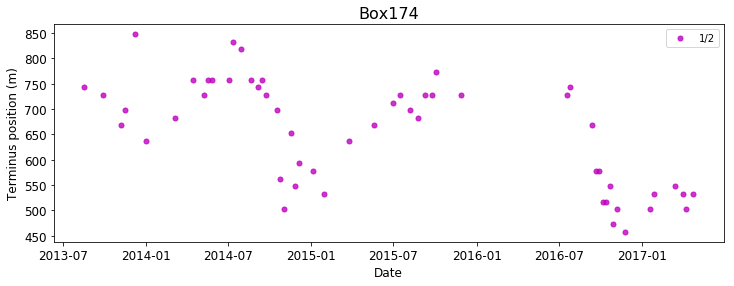

Box235


/home/jukes/automated-glacier-terminus/automated_terminus_functions.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['changerate'] = tchange


[11, 12, 30, 31, 32, 33, 49, 64, 65, 66, 67, 68, 73, 74, 75, 76, 77, 79, 98, 139, 140, 141, 142, 159, 162, 162, 168, 170, 172, 173, 174, 175, 179, 180, 181, 182, 190, 190, 193, 200, 236, 237, 237, 238, 239, 240, 247, 248, 249, 256, 258, 259, 260, 262, 263, 264, 279, 280, 281, 282, 283, 289, 290, 294, 294, 295, 295, 296, 296, 297, 297, 298, 298, 300, 301, 302, 303, 304, 310, 311, 312, 313, 314]
[47, 48, 49, 50, 51, 115, 116, 117, 118, 119, 132, 133, 134, 135, 148, 149, 150, 151, 152, 205, 207, 208, 209, 211, 212, 222, 234]
[122, 122, 123, 123]
[36, 52, 60, 61, 67, 81, 81, 87, 130, 130, 133, 133, 137, 138, 154, 191, 191, 200, 201, 202, 208, 227, 228, 232, 233, 234, 235, 236, 238, 239, 240, 241, 242]
[31, 32, 33, 34, 35, 40, 41, 42, 43, 44, 53, 53, 54, 54, 55, 55, 56, 56, 57, 57, 120, 121, 122, 188, 189, 190, 191]
[43, 44, 45, 105, 106, 170, 171, 172]
[10, 11, 12, 33, 34, 35, 36, 37, 49, 62, 63, 64, 65, 66, 71, 72, 73, 74, 75, 96, 97, 98, 99, 100, 114, 115, 141, 142, 143, 144, 145, 161, 1

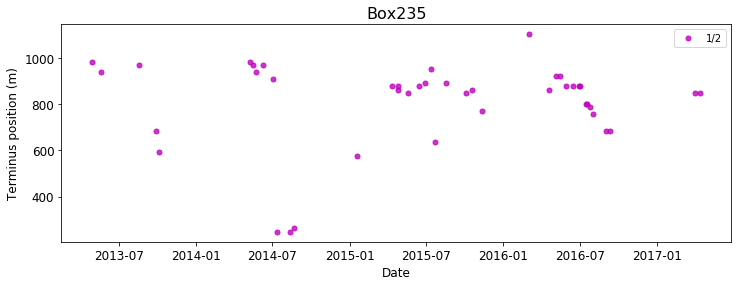

Box148


/home/jukes/automated-glacier-terminus/automated_terminus_functions.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['changerate'] = tchange


[22, 23, 24, 25, 31, 32, 33, 34, 35, 49, 50, 51, 52, 64, 65, 71, 72, 73, 74, 75, 89, 90, 91, 99, 100, 101, 121, 122, 123, 124, 125, 131, 133, 134, 135, 171, 172, 173, 179, 180, 181, 182, 183, 213, 214, 215, 216]
[]
[]
[19, 20, 21, 27, 28, 29, 30, 31, 58, 59, 60, 61, 75, 76, 90, 91, 92, 93, 94, 103, 104, 105, 106, 107, 113, 115, 134, 150, 151, 152, 158, 159, 160, 161, 184, 185]
[127]
[]
[31, 32, 33, 34, 35, 49, 50, 51, 52, 53, 63, 64, 83, 84, 85, 86, 87, 94, 115, 121, 122, 123, 137, 162, 163, 164, 165, 166, 194, 195, 196, 197, 198]
[112, 113, 114, 134, 135, 136, 137, 138]
[]
[14, 15, 16, 42, 43, 44, 45, 63, 74, 80, 81, 94, 112, 113, 120, 126, 127, 131, 132, 133, 134, 135, 148, 150, 151, 152, 165, 166, 167, 168, 169, 180]
[12, 13, 39, 40, 41, 42, 43, 56, 67, 68, 69, 70, 75, 76, 77, 78, 79, 101, 102, 103, 105, 114, 115, 116, 117, 118, 139, 140, 141, 142, 143]
[12, 13, 14, 15, 16, 85, 87, 88, 89, 93, 94, 95, 96, 97, 113, 113, 114, 114, 115, 115, 116, 116, 117, 117]
[63, 71, 72, 73, 74, 75,

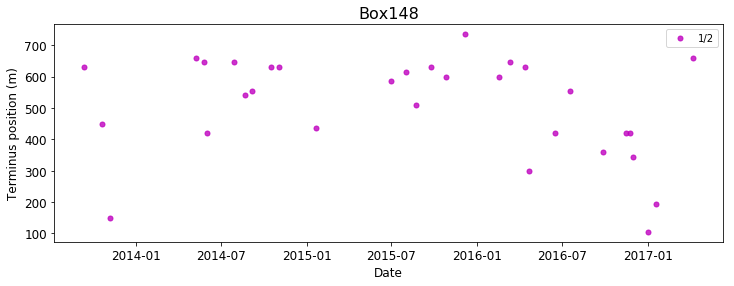

Box191


/home/jukes/automated-glacier-terminus/automated_terminus_functions.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['changerate'] = tchange


[98, 99, 100, 101, 102, 104, 105, 106, 107, 108]
[]
[]
[65, 66]
[]
[]
[49]
[]
[]
[31, 74, 75, 87, 87, 89, 90, 91]
[20, 21, 22, 23, 24, 84, 86, 87, 88, 90, 91]
[20, 21, 22, 23, 24, 68]
[51, 52, 53, 54, 78, 80, 80, 81, 81, 82, 82, 92]
[74]
[19, 20, 21, 22, 23, 61, 62, 63, 75, 76, 98, 99, 100, 101, 102]
[20, 21, 22, 23, 59, 60, 77, 78, 79, 86, 86]
[20, 21, 22, 23, 24]
[20, 21, 22, 23, 24]
23
24
19
23
24
19
23


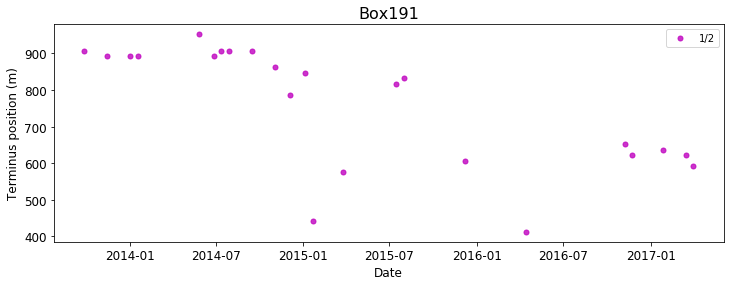

Box195
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
No points remaining. Processed stopped for Box195
No points remaining. Processed stopped for Box195
No points remaining. Processed stopped for Box195
Box214
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
No points remaining. Processed stopped for Box214
No points remaining. Processed stopped for Box214
No points remaining. Processed stopped for Box214
Box152


/home/jukes/automated-glacier-terminus/automated_terminus_functions.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['changerate'] = tchange


[5, 6, 7, 8, 9, 53, 54, 55, 56, 60, 61, 63, 64, 65, 66, 92, 93, 94, 95, 96, 107, 107, 108, 108, 109, 109, 118, 119, 128, 129, 191, 197, 198, 204, 205, 206, 207]
[6, 7]
[]
[1, 2, 3, 4, 5, 44, 45, 46, 47, 51, 52, 68, 69, 79, 80, 100, 139]
[]
[]
[6, 7, 8, 34, 35, 36, 37, 38, 62, 63, 64, 65, 70, 90, 91, 92, 93, 94, 101, 102, 103, 104, 112, 113, 114, 115, 121, 122, 123, 136, 145, 146, 147, 148, 149, 161, 162, 163, 164, 165, 194, 195, 196, 207, 208, 208, 209, 209, 210, 210]
[7, 8, 9, 10, 54, 55, 56, 57, 82, 154, 155, 156, 157, 158]
[50, 51, 52]
[5, 16, 17, 18, 19, 20, 36, 37, 50, 56, 57, 58, 59, 60, 61, 62, 63, 64, 81, 82, 83, 84, 93, 94, 95, 96, 97, 101, 105, 106, 107, 108, 114, 115, 121, 122, 124, 125, 126, 127, 128, 136, 137, 138, 154, 155, 156, 157, 167, 168, 169, 170, 171, 182, 183, 184, 185, 186]
[5, 5, 6, 6, 46, 47, 48, 49, 50, 51, 63, 64, 65, 66, 67, 77, 79, 110, 111, 112, 113]
[5, 6, 7, 44, 44, 45, 46, 47, 48, 73, 74, 95, 96]
[30, 31, 32, 33, 43, 44, 45, 46, 62, 63, 64, 81, 98, 99, 

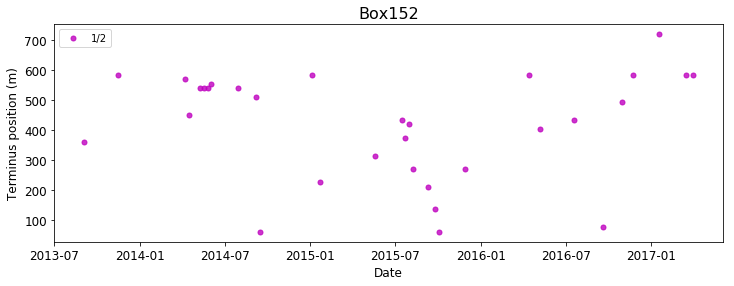

Box002


/home/jukes/automated-glacier-terminus/automated_terminus_functions.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['changerate'] = tchange


[39, 40, 41, 48, 49, 52, 52, 111]
[47, 48]
[]
[6, 37, 38, 39, 49, 49, 50, 50, 80, 92, 93, 94]
[72, 73]
[]
[]
[]
[]
[3, 4, 5, 6, 7, 35, 36, 37, 38, 42, 43, 44, 68, 69, 70, 71, 72, 80, 81, 82, 83, 84, 94, 95, 96, 97, 103, 104, 105]
[30, 33, 56]
[30, 30, 31, 54]
[19, 31, 32, 33, 34, 35, 38, 39, 40, 41, 43, 64, 65, 66, 67, 68, 83, 84]
[19, 53]
[52, 53]
[37, 38, 65, 69, 87, 95, 96, 97]
[40, 63]
[62]
26
21
31
26
21
31
26


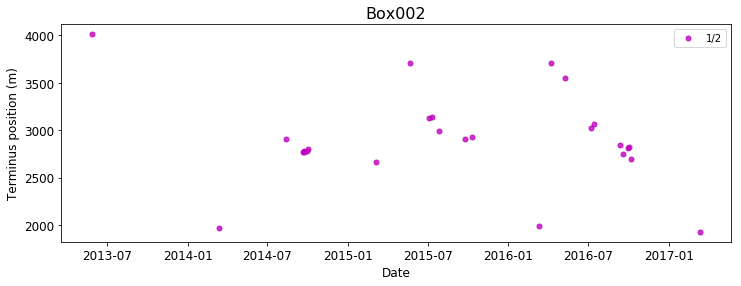

Box192
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
No points remaining. Processed stopped for Box192
No points remaining. Processed stopped for Box192
No points remaining. Processed stopped for Box192
Box004


/home/jukes/automated-glacier-terminus/automated_terminus_functions.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['changerate'] = tchange


[48, 49, 50, 65, 66, 67, 68, 102, 102, 103, 103, 104, 104, 122, 123, 124, 125, 126, 219, 220, 221, 222, 223, 227, 236, 236, 237, 237, 238, 238, 239, 239, 250, 251, 252, 253, 254, 296, 296, 297, 297, 300]
[112, 112, 113, 113, 114, 114, 115, 115, 204, 205, 207, 208, 209, 265]
[112, 113, 114]
[44, 45, 47, 48, 49, 89, 90, 91, 99, 99, 190, 190, 191, 191, 192, 192, 193, 193, 194, 194, 196, 202, 203, 250, 251]
[44, 91, 92, 93, 182, 182, 187, 188, 189, 190, 191]
[90, 91, 92]
[65, 66, 67, 86, 86, 96, 97, 98, 99, 147, 148, 149, 179, 179, 181, 182, 183, 184, 185, 266, 267, 268, 269, 270, 280, 280, 281, 281, 288, 294, 295, 300, 300, 301, 302, 303, 304, 306, 307, 308, 309, 316, 317, 318, 319, 320, 371, 372, 373, 374, 376, 376, 377, 377, 378, 378, 379, 380, 387]
[168, 249, 250, 251, 258, 259, 274, 331, 332]
[168, 169, 248, 249, 250, 251, 252, 254, 255, 256, 326]
[41, 42, 43, 44, 45, 46, 47, 50, 91, 92, 93, 94, 111, 132, 133, 134, 135, 196, 197, 200, 201, 202, 208, 209, 210, 211, 212, 221, 222, 234, 

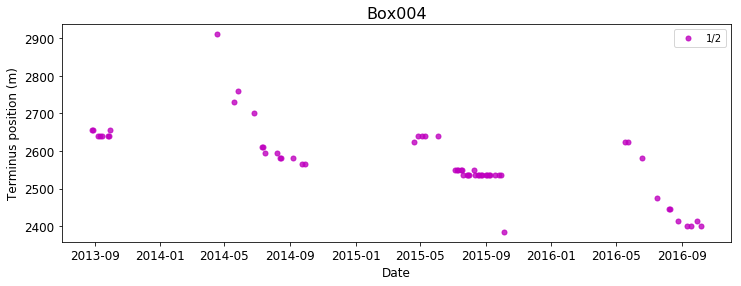

Box001


/home/jukes/automated-glacier-terminus/automated_terminus_functions.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['changerate'] = tchange


[15, 16, 17, 18, 19, 25, 25, 26, 26, 27, 27, 28, 28, 29, 29, 81, 82, 83, 84, 85, 115, 116, 117, 118, 119, 177, 178, 179, 180, 181, 242, 243, 244, 244, 245, 246, 246, 319, 319, 358, 359, 360, 361, 396, 402, 403, 404, 405, 406]
[71, 72, 73, 74, 75, 219, 220, 221, 327, 328, 329, 330, 331, 361, 361, 362, 362, 363, 363]
[71, 72, 73, 74, 75, 343, 344, 346]
[19, 19, 20, 20, 21, 21, 22, 22, 23, 23, 75, 76, 77, 78, 79, 109, 110, 111, 167, 168, 169, 170, 171, 232, 233, 234, 234, 235, 236, 236, 379]
[70, 71, 72, 73, 74, 216, 217, 218, 356, 356, 357, 357, 358, 358]
[70, 71, 72, 73, 74, 344, 345]
[15, 16, 17, 18, 19, 25, 25, 26, 26, 27, 27, 28, 28, 79, 80, 81, 82, 83, 114, 165, 166, 167, 168, 169, 232, 234, 237, 238, 239, 303, 303, 314, 315, 316, 317, 318, 319, 346, 347, 348, 349]
[70, 71, 72, 73, 74, 314, 315, 316, 317, 318]
[70, 71, 72, 73, 74]
[14, 15, 16, 17, 18, 19, 70, 71, 72, 73, 79, 90, 91, 105, 106, 201, 202, 203, 204, 205, 206, 220, 223, 231, 232, 265, 266, 267, 268, 269, 275, 276, 277, 2

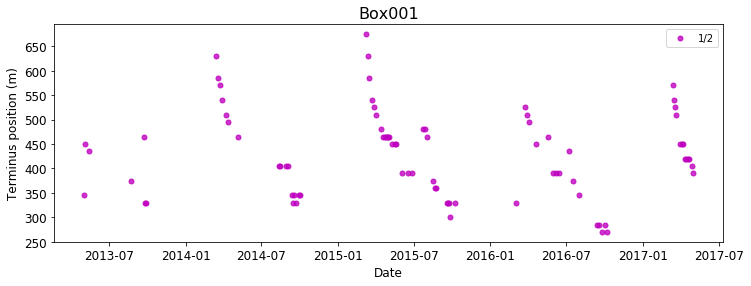

Box193
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
No points remaining. Processed stopped for Box193
No points remaining. Processed stopped for Box193
No points remaining. Processed stopped for Box193
Box277


/home/jukes/automated-glacier-terminus/automated_terminus_functions.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['changerate'] = tchange


[85, 86, 87, 88, 89, 105, 130, 156, 157, 158, 159, 160, 311, 315, 326, 327, 328]
[95, 96]
[]
[128, 178, 179, 180, 181, 282, 283, 343]
[]
[]
[55, 56, 57, 58, 74, 75, 84, 85, 86, 87, 88, 104, 157, 157, 158, 158, 164, 164, 170, 171, 180, 183, 184, 185, 221, 222, 223, 224, 274, 275, 299, 303, 314, 315, 316, 341, 342, 343, 344, 369, 370, 371]
[88, 89, 155, 168, 169]
[]
[29, 68, 69, 132, 133, 134, 135, 136, 171, 172, 173, 174, 175, 181, 182, 183, 184, 185, 201, 202, 203, 204, 205, 222, 223, 224, 225, 226, 238, 239, 240, 241, 305, 306, 307, 308, 309, 349, 350]
[44, 45, 46, 47, 48, 119, 120, 121, 122, 123, 129, 130, 131, 132, 133, 193, 199, 200, 201, 202, 203, 212, 213, 214, 273, 274, 290, 291, 292, 293, 294]
[44, 45, 46, 47, 48, 119, 120, 121, 122, 123]
[10, 11, 12, 23, 24, 25, 26, 27, 51, 52, 59, 60, 61, 62, 65, 66, 67, 90, 91, 92, 104, 105, 106, 107, 158, 159, 160, 161, 162, 167, 178, 179, 180, 181, 182, 188, 189, 190, 191, 192, 207, 208, 209, 210, 211, 228, 229, 230, 231, 232, 244, 245, 24

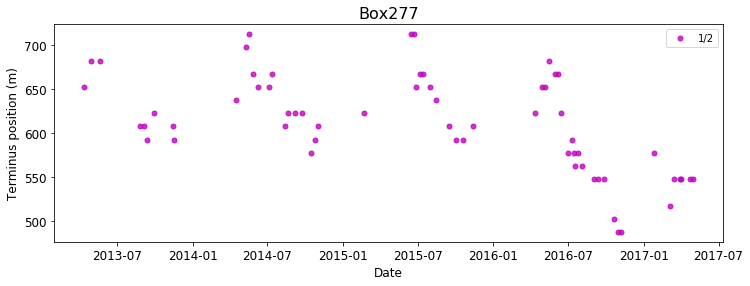

Box120


/home/jukes/automated-glacier-terminus/automated_terminus_functions.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['changerate'] = tchange


[235, 236, 237, 238, 239, 240, 352, 353, 354, 355, 356, 428, 429, 430, 431, 432]
[238]
[]
[344, 345, 346, 347, 348]
[]
[]
[201, 202, 230, 231, 232, 233, 420, 421, 422, 423]
[]
[]
[170, 171, 172, 173, 174, 206, 235, 431, 432, 433, 434]
[204, 205, 206, 207, 208, 233, 234, 235, 236, 237]
[228, 229, 230, 231, 232, 233, 234, 235, 236, 237]
[170, 171, 172, 173, 174, 190, 191, 192, 193, 194, 203, 231, 232, 233, 234, 235, 259, 260, 261, 262, 263, 314, 315, 316, 317, 318]
[195, 196, 197, 198, 199, 223, 224, 225, 226, 227]
[218, 219, 220, 221, 222, 223, 224, 225, 226, 227]
[189, 190, 191, 192, 193, 430, 431, 432, 433, 434]
[10, 11, 12, 13, 14, 228, 229, 230, 231, 232]
[223, 224, 225, 226, 227, 228, 229, 230, 231, 232]
64
66
66
90
88
89
90


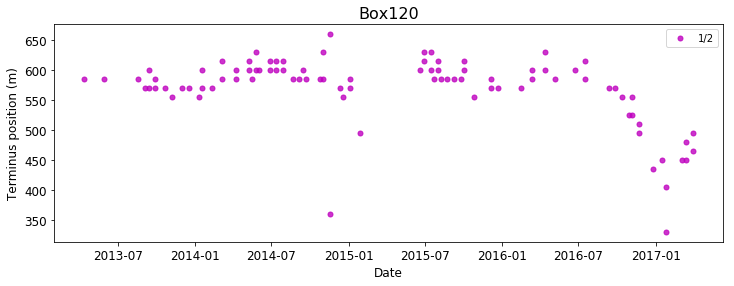

Box147


/home/jukes/automated-glacier-terminus/automated_terminus_functions.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['changerate'] = tchange


[8, 9, 10, 11, 12, 32, 32, 50, 51, 70, 71, 72, 78, 79, 80, 86, 88, 89, 110, 111, 112, 113, 114, 133, 134, 150, 157, 158, 159, 160, 176, 179, 180, 184, 184, 185, 185, 191, 192]
[75, 77, 113, 145, 146]
[77, 78]
[23, 31, 32, 33, 34, 40, 41, 59, 60, 61, 72, 74, 75, 88, 89, 97, 98, 103, 104, 108, 109, 147, 148, 154, 155]
[50, 51]
[]
[10, 11, 12, 13, 14, 46, 59, 60, 73, 77, 78, 79, 80, 114, 115, 132, 133, 149, 172, 175, 176, 180, 180, 186, 187, 215]
[]
[]
[3, 4, 5, 6, 7, 39, 41, 42, 43, 53, 54, 55, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 76, 77, 78, 96, 97, 100, 101, 102, 103, 104, 107, 108, 122, 134, 135, 136, 137, 138, 175, 176, 177, 178, 179]
[7, 8, 9, 10, 11, 44, 45, 46, 50, 51, 72, 76, 77, 78, 79, 80, 135, 136, 137, 138, 139]
[7, 8, 9, 10, 11, 41, 62, 63, 65, 66, 67, 68, 69, 76, 77, 78, 80]
[28, 29, 46, 61, 62, 78, 79, 84, 85, 85, 86, 86, 105, 106, 107, 109, 110, 120, 121, 124, 125, 126, 127, 128]
[8, 9, 10, 11, 12, 45, 46, 52, 53, 54, 55, 56, 73, 74, 75, 76, 96, 107, 108, 109, 110, 111

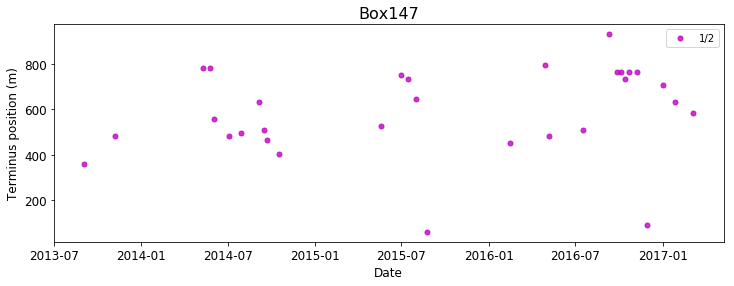

Box213
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
No points remaining. Processed stopped for Box213
No points remaining. Processed stopped for Box213
No points remaining. Processed stopped for Box213
Box194
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
No points remaining. Processed stopped for Box194
No points remaining. Processed stopped for Box194
No points remaining. Processed stopped for Box194
Box259


/home/jukes/automated-glacier-terminus/automated_terminus_functions.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['changerate'] = tchange


[31, 32, 54, 55, 56, 57, 58, 62, 63, 64, 65, 88, 88, 97, 115, 116, 117, 118]
[]
[]
[22, 23]
[]
[]
[41, 42, 67, 68, 69, 70, 88, 89, 90, 91, 92, 101, 146]
[82, 83, 84]
[82, 83, 84, 85, 86]
[3, 4, 5, 27, 28, 29, 33, 34, 35, 36, 48, 49, 50, 51, 72, 73, 75, 83, 84, 87, 88, 89, 90, 91, 95, 99, 100, 101, 102]
[3, 4, 27, 68, 76, 77]
[3, 4, 5, 6, 7, 14, 15, 31, 32, 34, 56, 65]
[3, 4, 5, 19, 20, 24, 25, 26, 27, 33, 48, 49, 62, 69, 74]
[3, 4, 5, 6, 7, 19, 26, 50, 51, 52]
[3, 4, 5, 6, 7, 18, 43, 43]
[1, 2, 31, 43, 44, 45, 46, 62, 63, 64, 76, 77, 78, 79, 80, 81, 91, 92, 93, 94, 98, 99, 105, 106, 107, 108, 109, 110, 111, 112, 113, 115, 122, 126, 129, 130]
[4, 5, 6, 22, 23, 35, 36, 40, 41, 49, 55, 56, 57, 58, 59, 86]
[4, 5]
26
21
33
26
21
33
26


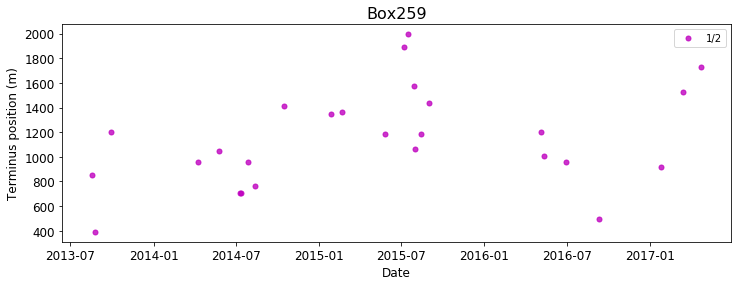

Box190


/home/jukes/automated-glacier-terminus/automated_terminus_functions.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['changerate'] = tchange


[93, 94, 95, 96]
[]
[]
[82, 83, 84, 85]
[]
[]
[41, 42, 85, 86, 87, 88]
[]
[]
[49, 50, 98, 99, 100, 101, 102]
[15, 16, 17, 18, 19, 49, 50, 51, 52, 53, 79, 80, 81, 82, 83, 96, 98, 99, 100]
[15, 16, 17, 18, 19, 44, 45, 46, 47, 48, 82, 83, 84, 85, 86]
[47, 47, 48, 48, 49, 49]
[15, 16, 17, 18, 47, 48, 49, 50, 51, 76, 77, 78, 85, 86, 87]
[15, 16, 17, 18, 19, 67, 68, 69, 70, 71]
[12, 13, 14, 15, 16, 22, 23, 24, 25, 26, 51, 52, 53, 54, 55, 71, 72, 73, 74, 75, 94, 95, 96]
[12, 13, 14, 15, 16, 41, 42, 43, 44, 45]
[12, 13, 14, 15, 16, 36, 37, 38, 39, 40]
17
17
15
17
17
15
17


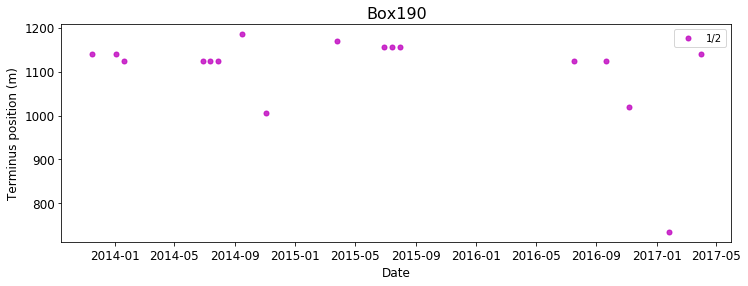

Box033


/home/jukes/automated-glacier-terminus/automated_terminus_functions.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['changerate'] = tchange


[91, 92, 93, 94, 95, 107, 108, 109, 110, 111, 168, 169, 170, 171, 172, 183, 184, 185, 186, 187, 198, 199, 200, 201, 212, 213, 214, 215, 216, 272, 273, 273, 274, 275]
[102, 103, 104, 105, 106, 107, 108, 109, 110, 111]
[]
[183, 184, 185, 186, 187, 257, 258, 259, 260, 261]
[]
[]
[110, 111, 112, 113, 114, 160, 161, 162, 163, 164, 175, 176, 177, 178, 179, 190, 191, 192, 193, 200, 201, 202, 203, 204, 258, 259, 260, 261, 262, 298, 355, 356, 357, 359]
[181, 182, 234, 235]
[]
[56, 57, 58, 59, 60, 68, 69, 70, 71, 72, 79, 80, 85, 101, 124, 125, 129, 130, 131, 190, 191, 192, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 219, 220, 221, 222, 225, 226, 227, 238, 239, 240, 241, 242, 243, 244, 245, 246, 276, 277, 278, 279, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334]
[40, 41, 42, 128, 188, 191, 192, 193, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 351, 352, 353]
[40, 41, 42, 43, 44, 45, 46, 47, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 186, 187, 188, 189, 190, 333, 334, 335, 336,

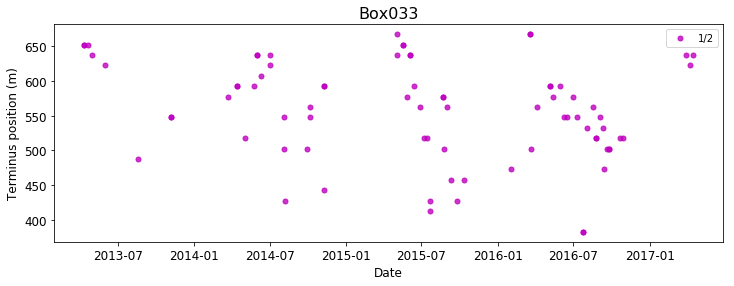

Box150


/home/jukes/automated-glacier-terminus/automated_terminus_functions.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['changerate'] = tchange


[25, 26, 27, 28, 29, 35, 36, 37, 38, 39, 45, 46, 47, 48, 49, 53, 62, 64, 68, 69, 70, 71, 72, 151, 152, 153, 154, 162, 163, 164, 165, 166, 196, 197, 198, 199, 200, 202, 203, 204, 205, 217, 218, 219, 220, 227, 228, 229, 230, 231, 241, 242, 243, 270, 271, 272]
[177, 178, 179, 180, 181, 188, 189, 190]
[]
[22, 23, 24, 25, 26, 29, 30, 31, 32, 33, 39, 40, 41, 42, 43, 52, 58, 59, 60, 61, 62, 73, 74, 75, 76, 87, 118, 119, 120, 121, 128, 129, 160, 161, 162, 163, 165, 166, 167, 168, 174, 175, 176, 177, 178, 187, 188, 189, 215, 216, 217]
[139, 140, 141]
[]
[21, 22, 23, 24, 25, 31, 32, 33, 34, 35, 37, 38, 39, 40, 41, 47, 48, 57, 58, 64, 65, 66, 67, 68, 122, 123, 124, 125, 126, 182, 183, 184, 185, 187, 193, 194, 195, 218]
[154, 155, 156, 157, 158]
[]
[13, 14, 30, 31, 32, 33, 34, 41, 42, 43, 47, 48, 49, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 109, 110, 111, 112, 113, 115, 116, 117, 118, 125, 126, 127, 130, 131, 132, 133, 134, 143, 143, 144, 144, 145, 145, 156, 157, 158, 159, 160, 165, 167, 168, 169, 

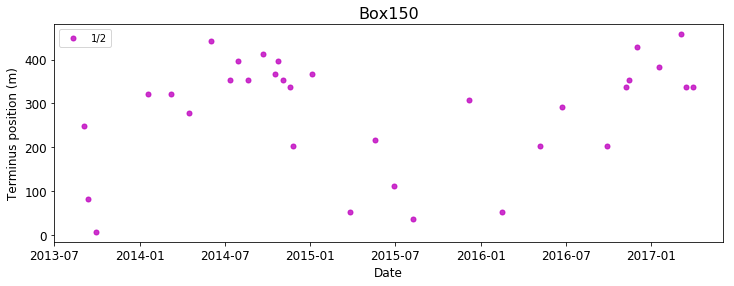

Box531


/home/jukes/automated-glacier-terminus/automated_terminus_functions.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['changerate'] = tchange


[5, 11, 12, 13, 14, 20, 20, 21, 21, 22, 22, 23, 23, 29, 29, 30, 30, 31, 31, 32, 32, 34, 51, 51, 63, 63, 64, 64, 74, 75, 76, 77]
[11, 12, 13, 14, 19, 19, 36, 48, 49, 50]
[10]
[5, 6, 7, 8, 14, 15, 42, 54, 55, 56, 57, 58, 73, 79, 80, 86, 86, 87, 87, 88, 93, 98]
[63, 65, 65, 71, 72]
[65, 66, 67, 68]
[4, 5, 6]
[]
[]
[14, 22, 23, 26, 27, 28, 29, 30, 31, 32, 33, 40]
[29]
[29, 29, 30, 30, 31, 31, 32, 32]
[3, 12, 13, 14, 15, 16, 19, 20, 21, 22, 23, 26, 38, 39, 43, 44, 45, 46, 56, 57, 58, 59, 61, 62, 63, 64, 70]
[38, 39]
[38]
[3, 11, 12, 13, 14, 15]
[4, 9, 10, 11, 12]
[7]
11
17
3
11
17
3
11


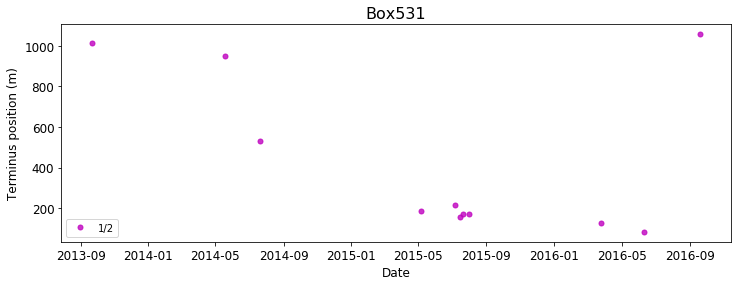

In [11]:
results_allglaciers(5, 3, 3) # try 5, 3, 3?